# **TP2: Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage**
- **Nom: Massyl Yanis HAMDI**
- **Num: 21118208**

## **Description**

L’objectif de ce TP est de réaliser une méthode d’alignement de points caractéristiques du visage inspirée de [1]. 

## **1 Préparation des données**

##### **1.1 Téléchargement des données**



La base est constituée de 4 sous-ensembles de données (Helen, AFW, LFPW et iBug) dont les images (extension .jpg ou .png) et les annotations (extension .pts) sont contenues dans les répertoires du même nom. On a également des fichiers .txt contenant la liste des données à utiliser pour l'apprentissage - 300w_train_images.txt et 300w_train_landmarks.txt respectivement pour la liste des images et des annotations - ainsi que pour les tests.

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import cv2
from tqdm import tqdm
import matplotlib.patches as patches

# Initialisation des listes vides pour stocker les images et les repères (landmarks)
images = []
landmarks = []

# Ouvre les fichiers contenant les chemins des images et des repères
with open('datasets/300w_train_images.txt', 'r') as path_images, open('datasets/300w_train_landmarks.txt', 'r') as path_keypoints:
    # Utilise tqdm pour afficher une barre de progression pendant la boucle
    for pathimg, pathkey in tqdm(zip(path_images, path_keypoints), desc="Loading images and landmarks"):
        # Construit les chemins complets vers les images et les repères
        path = 'datasets/' + pathimg.strip()
        landmark = 'datasets/' + pathkey.strip()
        
        # Charge l'image depuis le chemin
        img = io.imread(path)
        
        # Ajoute l'image à la liste des images
        images.append(io.imread(path))
        
        # Charge les repères depuis le fichier et les ajoute à la liste des repères
        landmarks.append(np.loadtxt(landmark))

print("Done loading images and landmarks")


Loading images and landmarks: 3148it [03:40, 14.30it/s]


Done loading images and landmarks


##### **1.2 Visualisation des données**

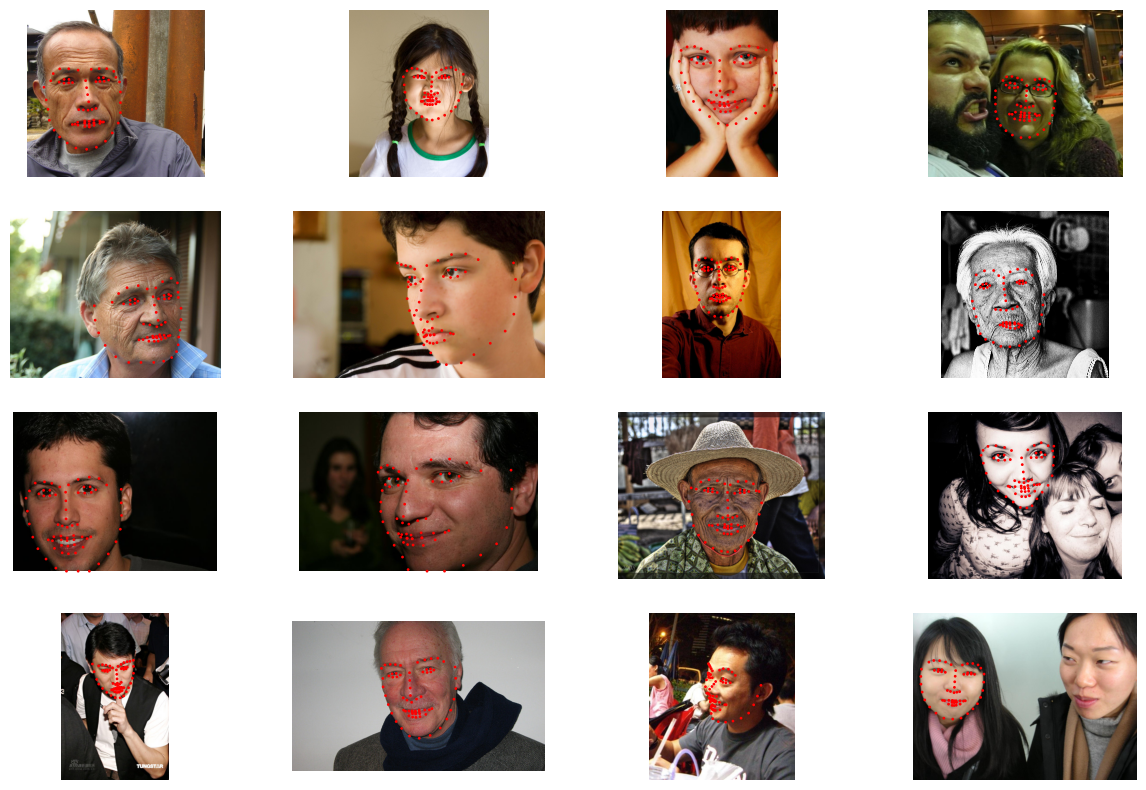

In [2]:
# On génère une liste d'indices d'images aléatoires de 0 à 3147 (3148 images au total).
index = sorted(random.sample(range(len(images)), 16))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i, ind in enumerate(index):
    ax[(i//4), (i % 4)].imshow(images[ind], cmap='gray')
    landmark = landmarks[ind]
    ax[(i//4), (i % 4)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
    ax[(i//4), (i % 4)].axis('off')


##### **1.3 Augmentation des données**

1.Calculer les paramètres de la boite englobante des points caractéristiques du visage

In [3]:
def bounding_box(image, keypoints, Expand_percent = None):
    """
    Calcule une boîte englobante autour des repères.

    Args:
        image (numpy.ndarray): L'image sur laquelle les repères sont détectés.
        keypoints (numpy.ndarray): Tableau de repères avec deux colonnes représentant les coordonnées x et y.
        Expand_percent (int, facultatif): Pourcentage d'expansion de la boîte englobante. Par défaut, None.

    Returns:
        tuple: Un tuple contenant les informations de la boîte englobante : (coin_sup_gauche, largeur, hauteur, coin_inf_droit).
    """

     # Calculer le pourcentage d'expansion.
    if isinstance(Expand_percent, int):
        Expand_percent = (Expand_percent/100) / 2
    else:
        Expand_percent = 0
    
    # Détermine les dimensions de l'image
    if (len(image.shape) == 3):
        image_width, image_height, _ = image.shape
    else :
        image_width, image_height = image.shape


    
    # Calcul des coordonnées du coin supérieur gauche
    coin_sup_gauche = (
        np.clip(keypoints[:, 0].min() - abs(keypoints[:, 0].max() - keypoints[:, 0].min()) * Expand_percent, a_min= 0, a_max=None),
        np.clip(keypoints[:, 1].min() - abs(keypoints[:, 1].max() - keypoints[:, 1].min()) * Expand_percent, a_min= 0, a_max=None)
    )

    # Calcul des coordonnées du coin inférieur droit 
    coin_inf_droit = (
        np.clip(keypoints[:, 0].max() + abs(keypoints[:, 0].max() - keypoints[:, 0].min()) * Expand_percent, a_min=None, a_max=image_height),
        np.clip(keypoints[:, 1].max() + abs(keypoints[:, 1].max() - keypoints[:, 1].min()) * Expand_percent, a_min=None, a_max=image_width)
    )

    # Calcul de la largeur et de la hauteur de la boîte englobante
    largeur = coin_inf_droit[0] - coin_sup_gauche[0]
    hauteur = coin_inf_droit[1] - coin_sup_gauche[1]

    return coin_sup_gauche, largeur, hauteur, coin_inf_droit

Affichage de quelque boite englobante des points caractéristiques du visage

Text(0.5, 0.98, 'image with the bounding box')

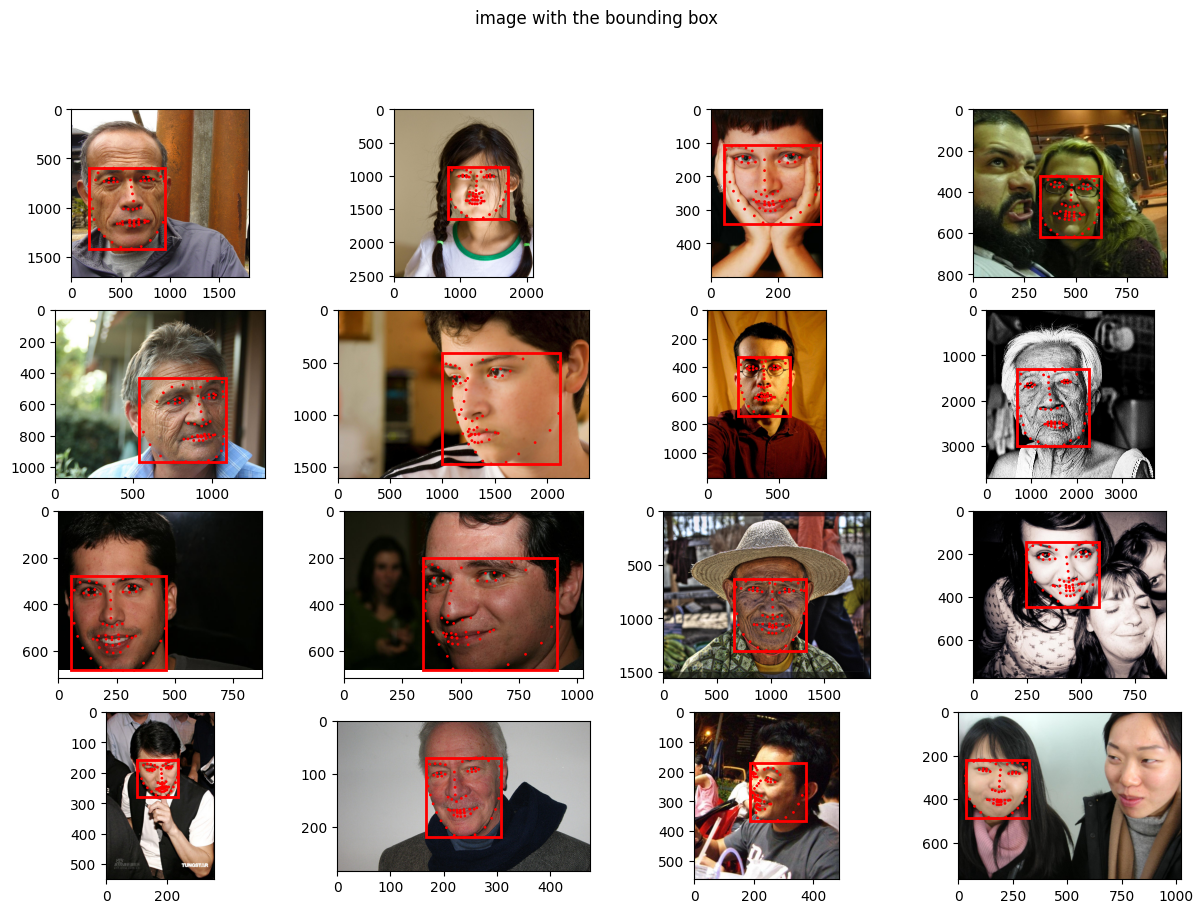

In [4]:
# Crée une grille de sous-graphiques de 3 lignes et 3 colonnes avec une taille de figure spécifiée
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

# Itère sur les indices sélectionnés aléatoirement
for i, ind in enumerate(index):
    ax[(i//4), (i % 4)].imshow(images[ind], cmap='gray')
    landmark = landmarks[ind]
    ax[(i//4), (i % 4)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
    # Calcule les informations de la boîte englobante
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(images[ind], landmark)
    rect = patches.Rectangle(coin_sup_gauche, largeur, hauteur, linewidth=2, edgecolor='r', facecolor='none')
    ax[(i//4), (i % 4)].add_patch(rect)
fig.suptitle('image with the bounding box')

2. Élargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, redimensionner l’image en 128 ∗ 128 et enregistrer l’image.

In [5]:
# Crée le Folder de sauvegarde s'il n'existe pas
save_dir = "./datasets/train_data_process"
os.makedirs(save_dir, exist_ok=True)

for i in tqdm(range(len(images)), desc="Processing images"):
    landmark = landmarks[i]
    new_image = images[i]
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(new_image, landmark, 30)

    # Recadre l'image en fonction de la boîte englobante
    image_cropped = new_image[int(coin_sup_gauche[1]):int(coin_inf_droit[1]), int(coin_sup_gauche[0]):int(coin_inf_droit[0])]

    
    # Redimensionne l'image à 128x128 pixels
    image_resized = cv2.resize(image_cropped, (128, 128))


    # Calcule les facteurs de redimensionnement
    if (len(image_cropped.shape) == 3) and (len(image_resized.shape) == 3):
        image_width, image_height, _ = image_cropped.shape
        newsize_w, newsize_h, _ = image_resized.shape
    else :
        image_width, image_height = image_cropped.shape
        newsize_w, newsize_h = image_resized.shape

    
    w_factor = image_width / newsize_w
    h_factor =  image_height / newsize_h

    # Ajuste les coordonnées des repères en fonction de la recadrage et de la redimension
    new_keypoint_cropped  = np.column_stack((np.array(landmark[:, 0]) - coin_sup_gauche[0], np.array(landmark[:, 1]) - coin_sup_gauche[1]))
    new_keypoint_resized = np.column_stack((new_keypoint_cropped[:, 0] / h_factor, new_keypoint_cropped[:, 1] / w_factor))

    # Définit les noms de fichier pour l'image et les repères
    fname_image = os.path.join(save_dir, f"train_data_process{str(i)}.jpg")
    fname_landmarks = os.path.join(save_dir, f"train_data_process{str(i)}.pts")

    # Sauvegarder
    io.imsave(fname_image, image_resized)
    np.savetxt(fname_landmarks, new_keypoint_resized)


Processing images: 100%|██████████| 3148/3148 [01:00<00:00, 52.22it/s] 


3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. La position des points constituera la vérité terrain (vous afficherez l’image et les points caractéristiques pour vérifier que ce prétraitement est effectif)


In [6]:
# images_proc = [io.imread(file) for file in glob.glob(f"datasets/data_processing/*.jpg")]    #les images sont desordonnées 
folder = "datasets/train_data_process" #Path

train_images = [] 
train_landmarks = []

for i in tqdm(range(len(images)), desc="loading images and landmarks"):
    # Nom du fichiers
    filename_images = f"train_data_process{str(i)}.jpg"
    filename_landmarks = f"train_data_process{str(i)}.pts"
    
    if os.path.isfile(os.path.join(folder, filename_images)):
        # Charger l'images
        train_images.append(io.imread(os.path.join(folder, filename_images)))

    if os.path.isfile(os.path.join(folder, filename_landmarks)):
        # Charger les landmarks
        train_landmarks.append(np.loadtxt(os.path.join(folder, filename_landmarks)))

loading images and landmarks: 100%|██████████| 3148/3148 [00:38<00:00, 81.87it/s]


Images et landmarks apres le processing:

Text(0.5, 0.98, 'image after processing')

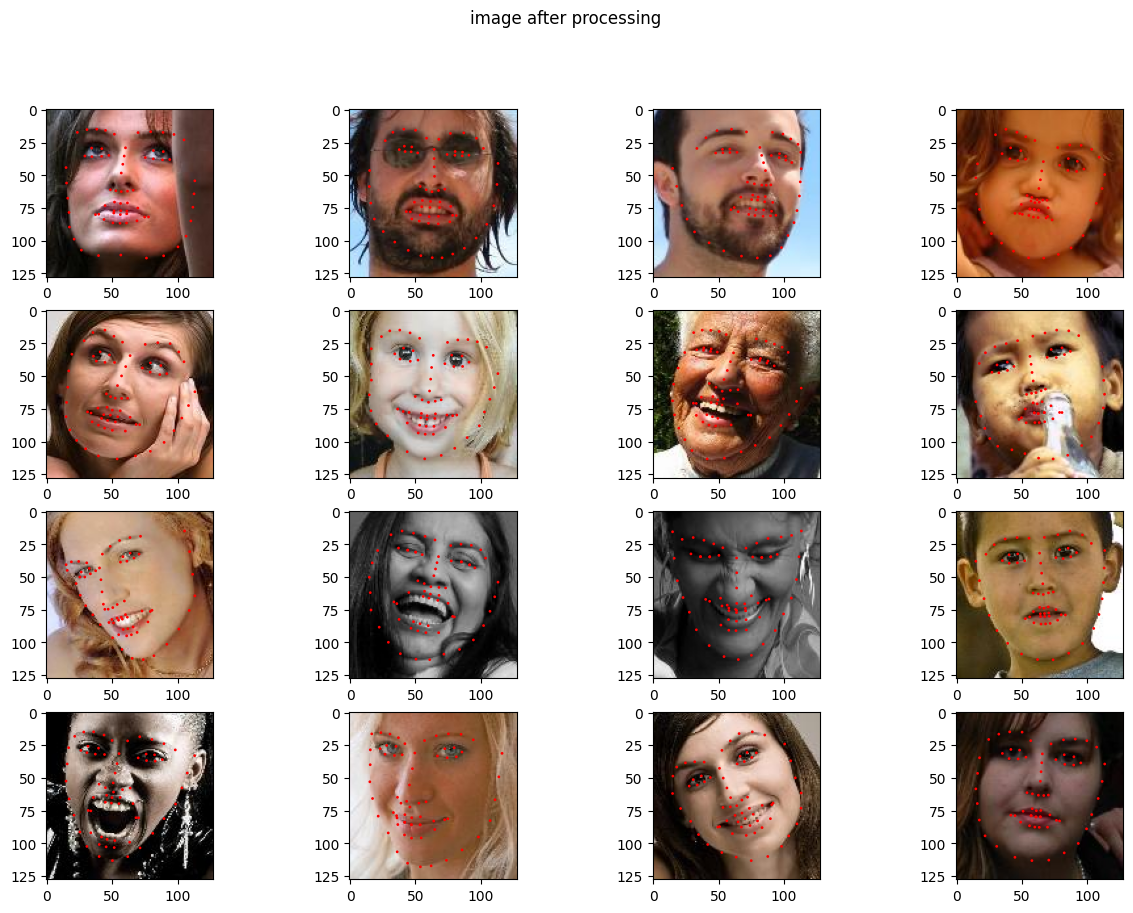

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i in range(16):
    ax[(i//4), (i % 4)].imshow(train_images[i], cmap='gray')
    landmark = train_landmarks[i]
    ax[(i//4), (i % 4)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
fig.suptitle('image after processing')

4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage

Text(0.5, 0.98, 'average landmarks')

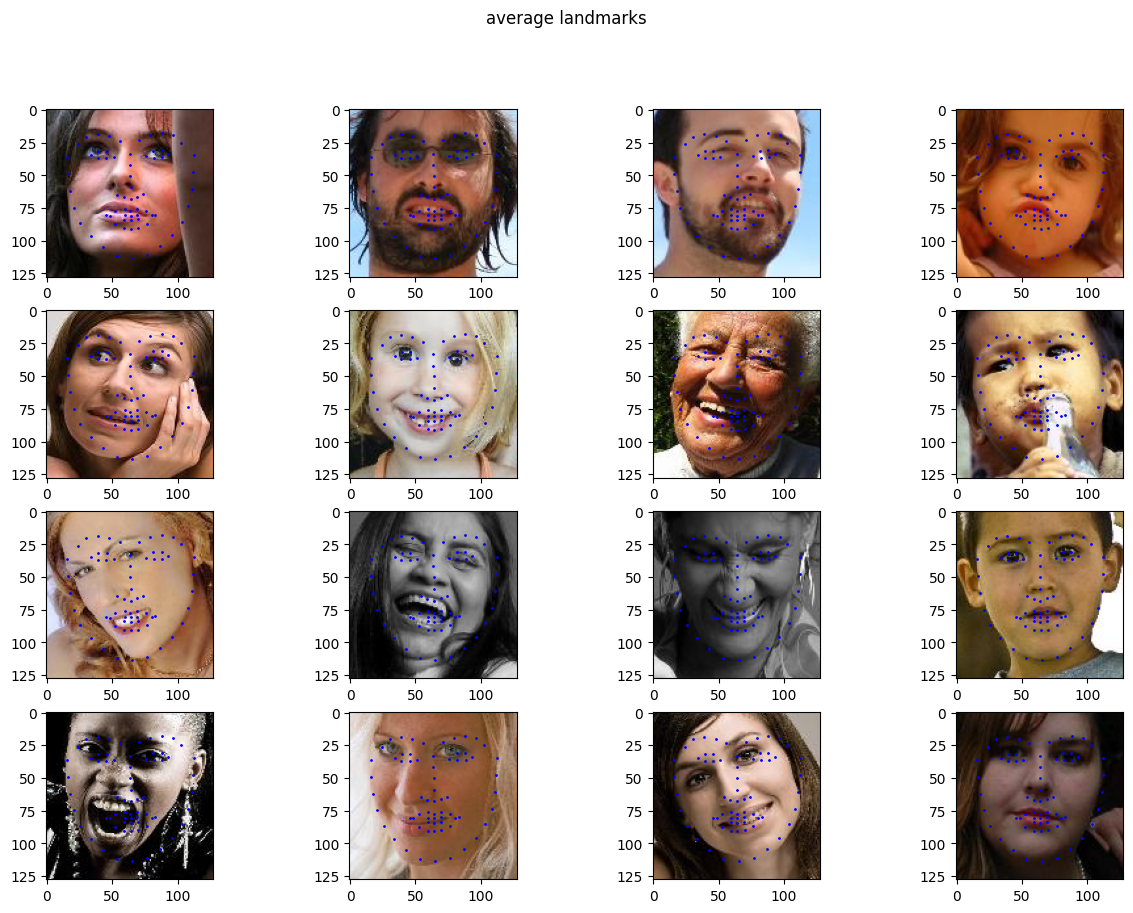

In [8]:
average_train_landmarks  = np.mean(np.array(train_landmarks),axis=0)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
for i in range(16):
    ax[(i//4), (i % 4)].imshow(train_images[i], cmap='gray')
    ax[(i//4), (i % 4)].scatter(average_train_landmarks[:, 0], average_train_landmarks[:, 1], s=1, facecolors='b')
fig.suptitle('average landmarks')

5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de
ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations
(indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une
méthode automatique pour déterminer l’amplitude de ces déplacements ?

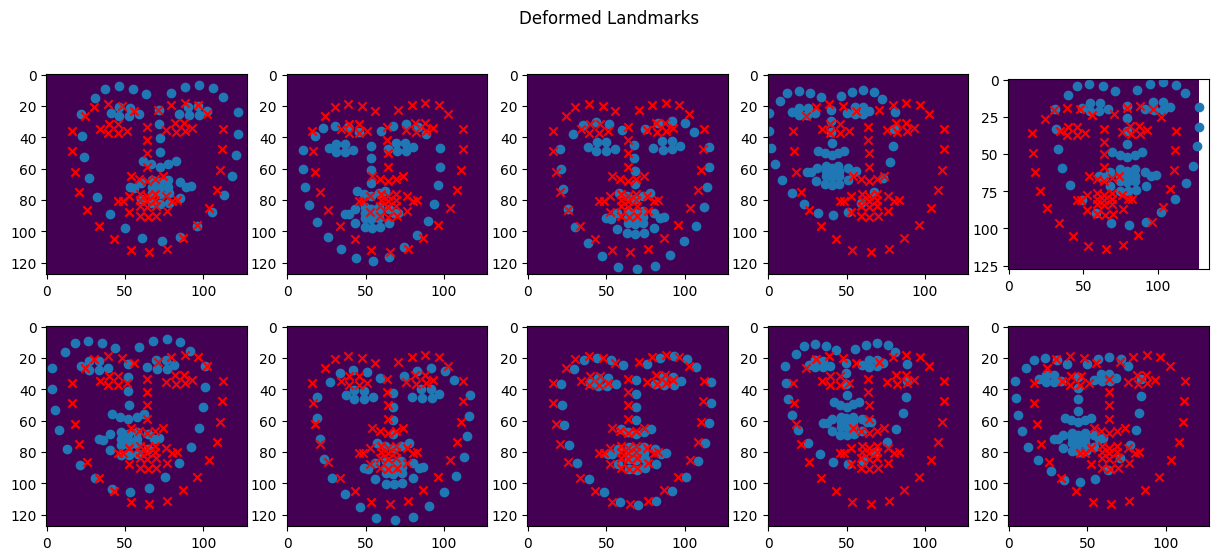

In [9]:
# Nombre de perturbations souhaitées
num_perturbations = 10

# Liste pour stocker les réalisations déformées
deformed_landmarks_list = []


fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Boucle sur le nombre de perturbations
for i in range(num_perturbations):
    while True:
        # Génère des valeurs aléatoires pour la translation en x et y dans la plage de ±20 pixels
        translation_x = np.random.uniform(-20, 20)
        translation_y = np.random.uniform(-20, 20)

        # Génère une valeur aléatoire pour le facteur d'échelle dans la plage de ±20%
        scale_factor = np.random.uniform(-0.2, 0.2)

        # Applique la translation et le facteur d'échelle à chaque point caractéristique
        deformed_landmarks = average_train_landmarks + np.array([translation_x, translation_y])
        deformed_landmarks = deformed_landmarks - (deformed_landmarks * scale_factor)

        # Vérifie si tous les points déformés sont à l'intérieur des limites de l'image
        if np.all((deformed_landmarks >= 0) & (deformed_landmarks < 128)):
            break

    # Stocke les nouvelles coordonnées déformées
    deformed_landmarks_list.append(deformed_landmarks)

    # Affiche ou enregistre les réalisations déformées selon vos besoins
    # Vous pouvez remplacer plt.show() par le code pour sauvegarder les réalisations déformées

    # Affiche la réalisation déformée
    ax[(i//5), (i % 5)].imshow(np.zeros((128,128), dtype=np.uint8))
    ax[(i//5), (i % 5)].scatter(deformed_landmarks[:, 0], deformed_landmarks[:, 1], label='Deformed Landmarks')
    ax[(i//5), (i % 5)].scatter(average_train_landmarks[:, 0], average_train_landmarks[:, 1], label='Mean Landmarks', marker='x', color='red')
fig.suptitle('Deformed Landmarks')
# Convertit la liste en un tableau NumPy
deformed_landmarks = np.array(deformed_landmarks_list)


L'utilisation de ces transformations contribue à accroître la diversité des données d'entraînement, ce qui est avantageux pour l'entraînement des modèles. En exposant le modèle à une plus grande variété de données, il apprend à mieux gérer les variations. Cela peut conduire à une amélioration des performances du modèle

## **2 Apprentissage d’un régresseur simple**

##### **2.1 Extraction de caractéristiques image**

1. Pourquoi ne peut-on pas utiliser directement les valeurs des pixels de l’image comme
représentation ?


Car elles ne contiennent pas suffisamment d'informations pour capturer la structure et les caractéristiques du point. En utilisant les valeurs des pixels voisins, on peut prendre en compte les relations spatiales entre les pixels et obtenir une représentation plus riche et significative de l'image. Cela permet de mieux capturer les contours, les textures et les motifs présents dans l'image.

2. Créer, pour chaque point caractéristique courant du modèle moyen, un objet
cv2.keyPoint en spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant
le diamètre du voisinage) de 20 pixels.

In [10]:
def key_points(average_landmarks, window_size = 20):
    """
    Convertit un ensemble de points de repère en objets cv2.KeyPoint.

    Args:
        average_landmarks (_type_): _description_
        window_size (int, optional): _description_. Defaults to 20.

    Returns:
        _type_: _description_
    """
    keypoints_list= []
    for point in average_landmarks:
        x, y = point    
        # Création d'un objet cv2.KeyPoint pour chaque point caractéristique
        keypoint = cv2.KeyPoint(x, y, window_size)

        # Ajout de l'objet cv2.KeyPoint à la liste
        keypoints_list.append(keypoint)
        
    return keypoints_list

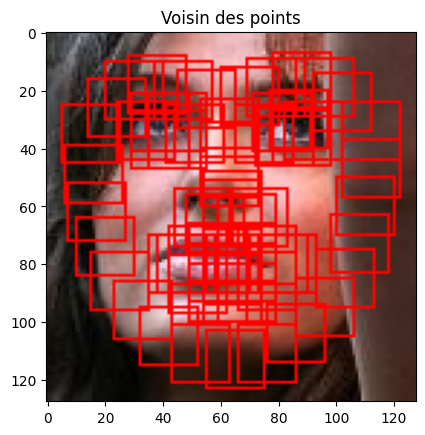

In [11]:

keypoints = key_points(average_train_landmarks,20)

img = train_images[0].copy()
for keypoint in keypoints:
    x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
    size = int(keypoint.size)
    img = cv2.rectangle(img, (x - size // 2, y - size // 2), (x + size // 2, y + size // 2), (255, 0, 0), 1)

plt.imshow(img)
plt.title("Voisin des points")
plt.show()

3. Utiliser la fonction sift.compute de OpenCV pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. Quelle est la dimensionnalité de chacun de ces descripteurs ?
4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. Quelle est la dimension de ce descripteur ?

In [12]:
descriptors = []
for ind in range(len(train_images)):
    for i in range(10):
        # instance SIFT
        sift = cv2.SIFT_create()
        #Génération des keypoints
        keypoints = key_points(deformed_landmarks[i],20)
        # Application de l'algorithme SIFT 
        _, descriptor = sift.compute(train_images[ind], keypoints)
        # Store the descriotors
        descriptors.append( descriptor.flatten())

In [13]:
# Convertit la liste en un tableau NumPy
descriptors_array = np.array(descriptors)
print("dimension de chaque descripteur SIFT:", descriptors_array.shape[1])
print("dimension du descripteur SIFT sur l'ensemble des images :", descriptors_array.shape)

dimension de chaque descripteur SIFT: 8704
dimension du descripteur SIFT sur l'ensemble des images : (31480, 8704)


##### **2.2 Réduction de la dimensionalité**

1. Quel est l’intérêt principal de la réduction de la dimensionnalité en machine learning ?Quelles sont les principales méthodes de réduction de la dimensionnalité ?


La réduction de la dimensionnalité diminue la complexité du modèle, rendant l'entraînement plus rapide et souvent plus efficace. ajouter a cela on diminue le risque de surapprentissage et élime les caractéristiques redondantes ou peu informatives.



Les principales méthodes de réduction de la dimensionnalité :

- Analyse en Composantes Principales (PCA).
- Autoencodeur (Linear autoencodedur).

2. Utiliser l’analyse en composante principale (ACP ou PCA en anglais - librairies OpenCV ou skimage, au choix) en conservant 98% de la variance totale des descripteurs.


In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(descriptors)

array([[-1.27924128e+03,  1.00857111e+02, -8.16487962e+02, ...,
         4.83013031e-02, -3.74834172e-02, -9.32966330e-03],
       [-1.62505452e+02, -8.71373068e+02,  4.00505553e+02, ...,
         8.05412108e-04, -7.33178794e-02,  1.22595483e-02],
       [-1.32696786e+03, -5.76107588e+02,  1.80437650e+02, ...,
        -1.44555173e-01, -1.23568279e-01,  6.91482762e-02],
       ...,
       [ 6.34810326e+01, -5.86427514e+02, -3.15032886e+02, ...,
        -3.47789372e-03, -2.32243749e-02, -3.18767846e-02],
       [ 1.13013267e+03, -4.01389674e+02, -2.12832541e+02, ...,
         4.55894800e-02, -1.31771328e-02, -2.54062296e-02],
       [ 1.40506839e+03, -2.50101969e+02,  8.70165914e+01, ...,
         4.51702621e-02, -5.95952515e-03, -7.42761254e-04]])

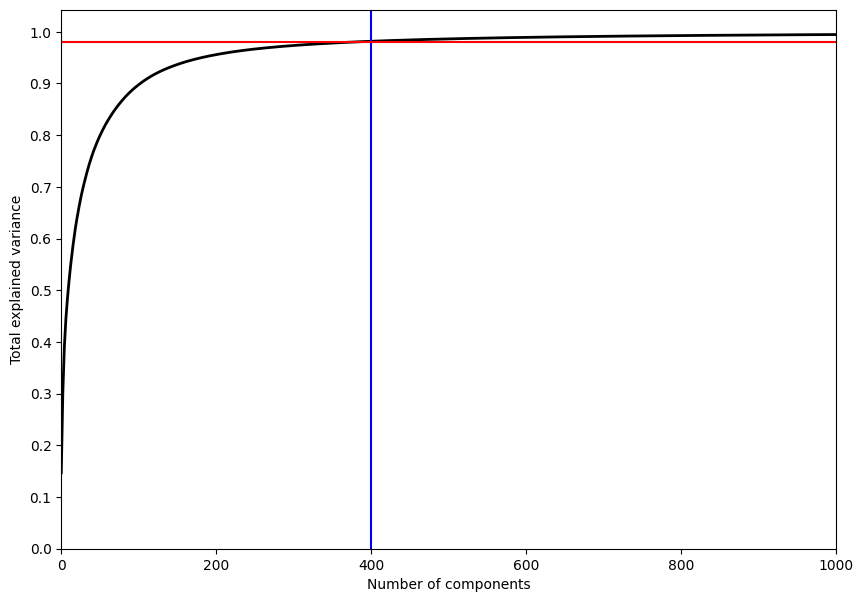

In [15]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 1000)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(400, c='b')
plt.axhline(0.98, c='r')
plt.show()

À partir de cette figure, il est possible de conclure qu'en préservant 98% de la variance totale des descripteurs, on peut conserver 400 composantes. Cette observation indique que ces 400 composantes conservent l'essentiel de l'information présente dans les données.

In [16]:
# Application de PCA sur les descripteurs pour n_components=0.98.
pca = PCA(n_components=0.98)
X0_ = pca.fit_transform(descriptors)

3. Quelles sont les dimensions de la matrice X0_ obtenue par réduction de la dimensionnalité?

In [17]:
A0 = pca.components_

print("dimension de la matrice X0_:", X0_.shape)
print("dimension de la matrice A0 :", A0.shape)

dimension de la matrice X0_: (31480, 376)
dimension de la matrice A0 : (376, 8704)


376 composantes conservent l'essentiel de l'information présente dans les données.

##### **2.3 Estimation du déplacement**

1. Calculer R0 et b0 en appliquant une résolution aux moindres carrés (b0 peut être supprimé en ajoutant une ligne de 1 à X0)

In [18]:
# Calcule du delta optimale 
def delta(train_landmarks,deformed_landmarks):
    delta =  np.zeros((np.array(train_landmarks).shape[0]*10, 136))
    for i in range(31480):
        delta[i, :] = train_landmarks[i//10].flatten() - deformed_landmarks[i%10].flatten()
    return delta

In [19]:
from sklearn import linear_model

#delta opti
delt = delta(train_landmarks,deformed_landmarks)

# Entraîne le modèle de régression linéaire.
reg = linear_model.LinearRegression()
reg.fit(X0_, delt)

R0 = reg.coef_
b0 = reg.intercept_

2. Calculer l’erreur de prédiction (MAE : mean absolute error sur la base d’apprentissage. Afficher, pour la première image de la base, les points caractéristiques initiaux s0 (en vert) ainsi que les points déplacés s0 + δs. Que peut-on en conclure ?

In [20]:
from sklearn.metrics import mean_absolute_error
delt_regression =  np.dot(X0_, R0.T) + b0
mae = mean_absolute_error(delt, delt_regression)
print(f"l’erreur de prédiction: {mae}")

l’erreur de prédiction: 3.701796984544858


Text(0.5, 1.0, 'Points caractéristiques initiaux et déplacés')

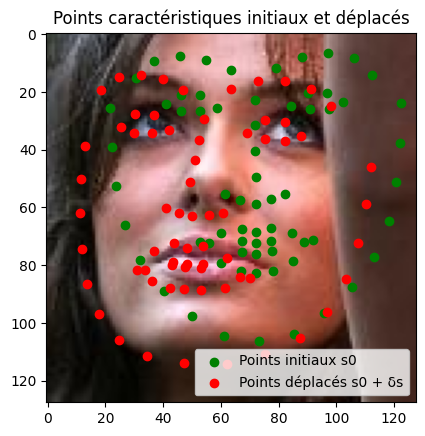

In [21]:
delt_regression = delt_regression.reshape(31480, 68, 2)

# Afficher les points caractéristiques initiaux s0 (en vert) et les points déplacés s0 + δs (en rouge)
plt.imshow(train_images[0])
plt.scatter(deformed_landmarks[0][:, 0], deformed_landmarks[0][:, 1], color='green', label='Points initiaux s0')
plt.scatter((deformed_landmarks[0] + delt_regression)[0][:, 0], (deformed_landmarks[0] + delt_regression)[0][:, 1], color='red', label='Points déplacés s0 + δs')
plt.legend()
plt.title('Points caractéristiques initiaux et déplacés')

3. En quoi l’évaluation précédente n’est-elle pas pertinente pour évaluer la capacité de généralisation de la procédure d’alignement de points caractéristiques ?

L'erreur ayant été calculée sur la base d'apprentissage, cela peut induire en erreur quant à la véritable robustesse de notre modèle. En effet, cela pourrait masquer un potentiel surapprentissage, c'est-à-dire que le modèle serait optimisé pour les données spécifiques d'entraînement mais manquerait de généralisation pour de nouvelles données. Cela signifie que, bien que le modèle semble performant sur les données d'apprentissage, il pourrait ne pas maintenir ce niveau de performance lorsqu'il est confronté à des données qu'il n'a jamais vues auparavant.

4. Calculer l’erreur de prédiction sur le set de test et afficher, pour la première image de la base, les points caractéristiques initiaux s0 (en vert) ainsi que les points déplacées s0+s. Que peut-on en conclure ?

In [22]:
# Initialisation des listes vides pour stocker les images et les repères (landmarks)
images_test = []
landmarks_test = []

# Ouvre les fichiers contenant les chemins des images et des repères
with open('datasets/helen_testset.txt', 'r') as path_images, open('datasets/helen_testset_landmarks.txt', 'r') as path_keypoints:
    # Utilise tqdm pour afficher une barre de progression pendant la boucle
    for pathimg, pathkey in tqdm(zip(path_images, path_keypoints), desc="Loading images and landmarks"):
        # Construit les chemins complets vers les images et les repères
        path = 'datasets/' + pathimg.strip()
        landmark = 'datasets/' + pathkey.strip()
        
        # Charge l'image depuis le chemin
        img = io.imread(path)
        
        # Ajoute l'image à la liste des images
        images_test.append(io.imread(path))
        
        # Charge les repères depuis le fichier et les ajoute à la liste des repères
        landmarks_test.append(np.loadtxt(landmark))

print("Done loading images and landmarks")

Loading images and landmarks: 330it [00:17, 18.64it/s]

Done loading images and landmarks


In [24]:
# Crée le Folder de sauvegarde s'il n'existe pas
save_dir = "./datasets/test_data_process"
os.makedirs(save_dir, exist_ok=True)

for i in tqdm(range(len(images_test)), desc="Processing images"):
    landmark = landmarks_test[i]
    new_image = images_test[i]
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(new_image, landmark, 30)

    # Recadre l'image en fonction de la boîte englobante
    image_cropped = new_image[int(coin_sup_gauche[1]):int(coin_inf_droit[1]), int(coin_sup_gauche[0]):int(coin_inf_droit[0])]

    
    # Redimensionne l'image à 128x128 pixels
    image_resized = cv2.resize(image_cropped, (128, 128))


    # Calcule les facteurs de redimensionnement
    if (len(image_cropped.shape) == 3) and (len(image_resized.shape) == 3):
        image_width, image_height, _ = image_cropped.shape
        newsize_w, newsize_h, _ = image_resized.shape
    else :
        image_width, image_height = image_cropped.shape
        newsize_w, newsize_h = image_resized.shape

    
    w_factor = image_width / newsize_w
    h_factor =  image_height / newsize_h

    # Ajuste les coordonnées des repères en fonction de la recadrage et de la redimension
    new_keypoint_cropped  = np.column_stack((np.array(landmark[:, 0]) - coin_sup_gauche[0], np.array(landmark[:, 1]) - coin_sup_gauche[1]))
    new_keypoint_resized = np.column_stack((new_keypoint_cropped[:, 0] / h_factor, new_keypoint_cropped[:, 1] / w_factor))

    # Définit les noms de fichier pour l'image et les repères
    fname_image = os.path.join(save_dir, f"test_data_process{str(i)}.jpg")
    fname_landmarks = os.path.join(save_dir, f"test_data_process{str(i)}.pts")

    # Sauvegarder
    io.imsave(fname_image, image_resized)
    np.savetxt(fname_landmarks, new_keypoint_resized)

Processing images: 100%|██████████| 330/330 [00:01<00:00, 284.97it/s]


In [79]:
# images_proc = [io.imread(file) for file in glob.glob(f"datasets/data_processing/*.jpg")]    #les images sont desordonnées 
folder = "datasets/test_data_process" #Path

test_images = [] 
test_landmarks = []

for i in tqdm(range(len(images_test)), desc="loading images and landmarks"):
    # Nom du fichiers
    filename_images = f"test_data_process{str(i)}.jpg"
    filename_landmarks = f"test_data_process{str(i)}.pts"
    
    if os.path.isfile(os.path.join(folder, filename_images)):
        # Charger l'images
        test_images.append(io.imread(os.path.join(folder, filename_images)))

    if os.path.isfile(os.path.join(folder, filename_landmarks)):
        # Charger les landmarks
        test_landmarks.append(np.loadtxt(os.path.join(folder, filename_landmarks)))

loading images and landmarks: 100%|██████████| 330/330 [00:00<00:00, 341.08it/s]


Text(0.5, 0.98, 'images test')

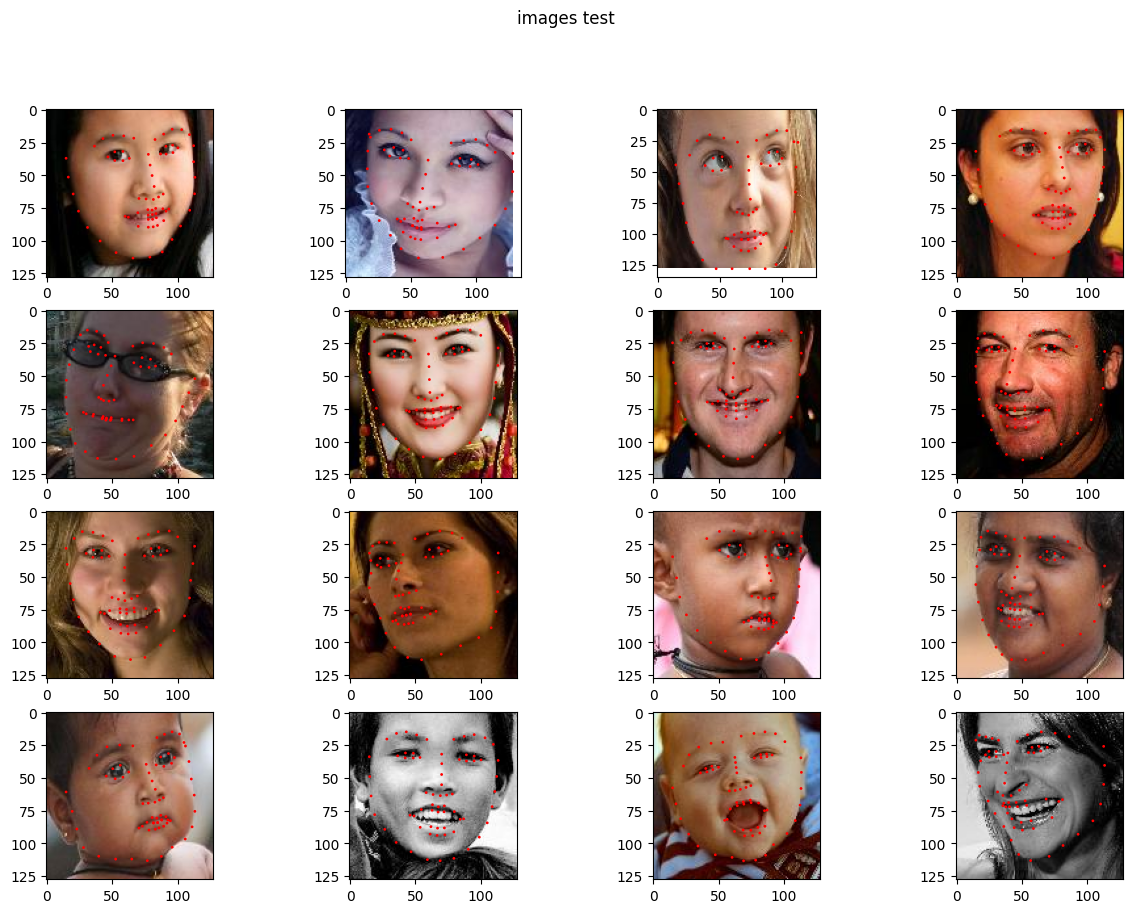

In [78]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i in range(16):
    ax[(i//4), (i % 4)].imshow(test_images[i], cmap='gray')
    landmark = test_landmarks[i]
    ax[(i//4), (i % 4)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
fig.suptitle('images test')

In [62]:

average_landmarks  = np.mean(np.array(test_landmarks),axis=0)
descriptors_test = []
for ind in range(len(test_images)):
    # instance SIFT
    sift = cv2.SIFT_create()
    #Génération des keypoints
    keypoints = key_points(average_landmarks,20)
    # Application de l'algorithme SIFT 
    _, descriptor = sift.compute(train_images[ind], keypoints)
    # Store the descriotors
    descriptors_test.append( descriptor.flatten())

In [97]:
X0_ = np.dot(np.array(descriptors_test), A0.T)
delt_test =  np.dot(X0_, R0.T)


In [98]:
# Calcule du delta optimale pour test
def delta_(test_landmarks, average_landmarks):
    delta =  np.zeros((np.array(test_landmarks).shape[0], 136))
    for i in range(len(test_landmarks)):
        delta[i, :] = test_landmarks[i].flatten() - average_landmarks.flatten()
    return delta

delt = delta_(test_landmarks,average_train_landmarks)

In [99]:
mae = mean_absolute_error(delt, delt_test)
print(f"l’erreur de prédiction: {mae}")

l’erreur de prédiction: 17.99613668344033


L'erreur de prédiction est nettement plus élevée sur l'ensemble de test par rapport à celle observée sur l'ensemble d'apprentissage, ce qui indique un potentiel problème de surapprentissage. Cela suggère que, bien que le modèle ait appris efficacement les particularités des données d'apprentissage, il n'a pas réussi à généraliser ces connaissances pour performer correctement sur des données inédites. En d'autres termes, le modèle est très précis sur les données qu'il a déjà vues, mais sa performance se dégrade considérablement lorsqu'il est confronté à de nouvelles données, ce qui est caractéristique du surapprentissage.

Structure des données

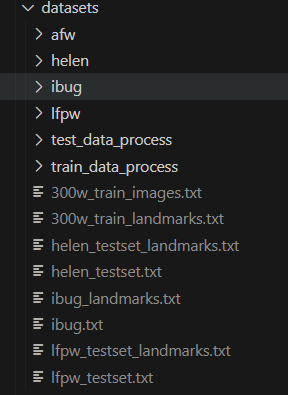